#Employee Atrition Prediction

In [ ]:
#importing dependencies
import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [ ]:
#importing machine learning models/gradient boosting algorithms
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

#mtrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
#importing the employee dataset
ibm_df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv')
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in ibm_df.columns:
    obs = ibm_df[col].size
    p_nan = round(ibm_df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({ibm_df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

numerical.remove('EmployeeCount')
numerical.remove('StandardHours')
pd.set_option('display.max_columns', 100)

In [ ]:
display(ibm_df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
#viewing the details of the dataset labels
display(description)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-1,1-2068,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,1 labels,2 labels,11-25,3-4,1-4,80-80,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


#Data Exploration and Analysis

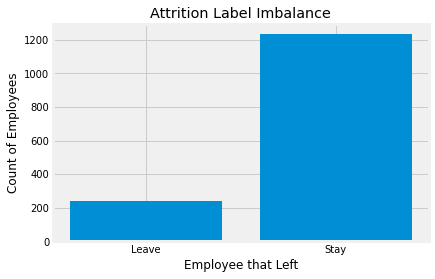

In [ ]:
count_yes = ibm_df.Attrition[ibm_df.Attrition == 'Yes'].size
count_no = ibm_df.Attrition[ibm_df.Attrition == 'No'].size

plt.bar(['Leave', 'Stay'], [count_yes, count_no])
plt.title('Attrition Label Imbalance')
plt.xlabel('Employee that Left')
plt.ylabel('Count of Employees')
plt.show()

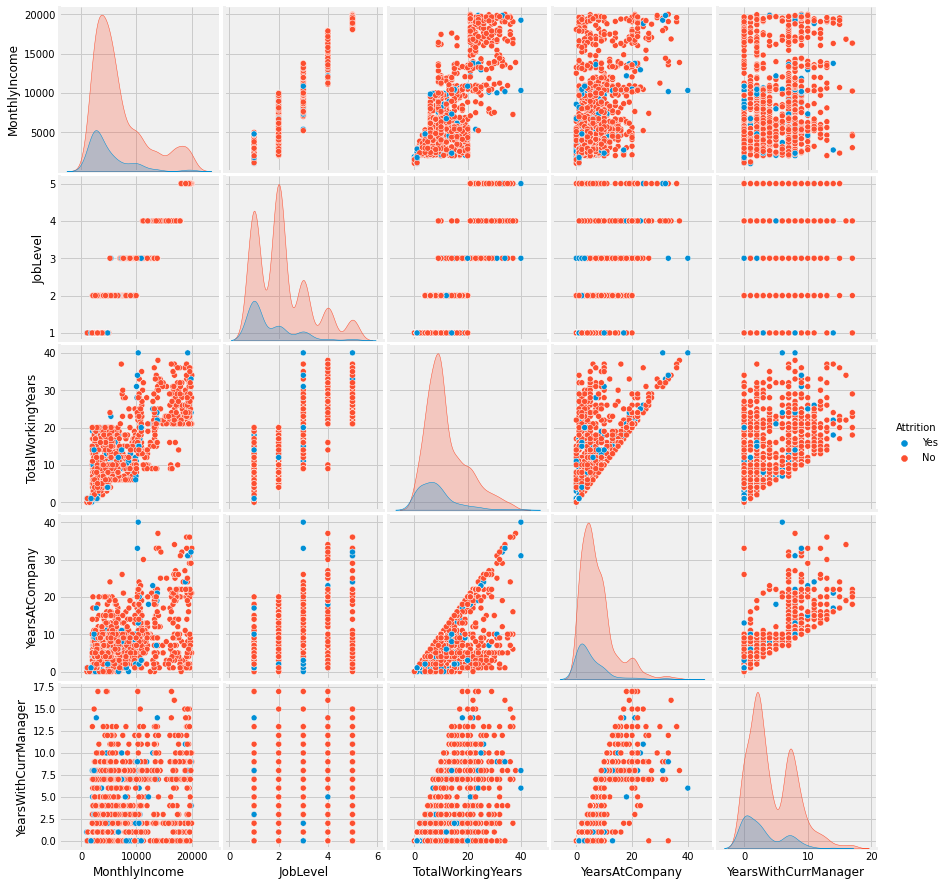

In [ ]:
features = ['MonthlyIncome', 'Attrition', 'JobLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager']
pairplot = sns.pairplot(ibm_df[features], diag_kind='kde', hue='Attrition')
plt.show()

#Model Building

In [ ]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [ ]:
xgb_data = ibm_df.copy()
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_data = pd.concat([xgb_dummy, xgb_data], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

In [ ]:
y_df = xgb_data['Attrition'].reset_index(drop=True)
x_df = xgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def xgb_objective(space, early_stopping_rounds=50):
    
    model = XGBClassifier(
        learning_rate = space['learning_rate'], 
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        min_child_weight = space['m_child_weight'], 
        gamma = space['gamma'], 
        subsample = space['subsample'], 
        colsample_bytree = space['colsample_bytree'],
        objective = 'binary:logistic'
    )

    model.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              eval_metric = 'auc',
              early_stopping_rounds = early_stopping_rounds,
              verbose = False)
     
    predictions = model.predict(test_x)
    test_preds = model.predict_proba(test_x)[:,1]
    train_preds = model.predict_proba(train_x)[:,1]
    
    xgb_booster = model.get_booster()
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions) 

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

trials = Trials()
xgb_hyperparams = fmin(fn = xgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
display(xgb_results)

100%|██████████| 150/150 [01:15<00:00,  2.00it/s, best loss: 0.15947712418300652]


{'model': 'XGBoost',
 'parameter search time': '0:01:15.138000',
 'accuracy': 0.881,
 'test auc score': 0.841,
 'training auc score': 0.927,
 'parameters': {'colsample_bytree': 0.8,
  'gamma': 0.8500000000000001,
  'learning_rate': 0.253086740869439,
  'm_child_weight': 5.0,
  'max_depth': 1.0,
  'n_estimators': 875.0,
  'subsample': 0.8500000000000001}}

**LightBoost**

In [ ]:
lgb_data = ibm_df.copy()
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)
lgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

y_df = lgb_data['Attrition'].reset_index(drop=True)
x_df = lgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def lgb_objective(space, early_stopping_rounds=50):
    
    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']), 
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )
    
    lgbm.fit(train_x, train_y, 
            eval_set = [(train_x, train_y), (test_x, test_y)],
            early_stopping_rounds = early_stopping_rounds,
            eval_metric = 'auc',
            verbose = False)
    
    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(train_x)[:,1]
    
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)  

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

100%|██████████| 150/150 [00:17<00:00,  8.35it/s, best loss: 0.16887183903546543]


{'model': 'LightGBM',
 'parameter search time': '0:00:17.967000',
 'accuracy': 0.867,
 'test auc score': 0.831,
 'training auc score': 0.886,
 'parameters': {'colsample_bytree': 0.6055224605726469,
  'feature_fraction': 0.6809983786544856,
  'learning_rate': 0.294881909583302,
  'max_depth': 1.0,
  'min_split_gain': 0.028692009378766464,
  'n_estimators': 800.0,
  'num_leaves': 90.0,
  'reg_alpha': 0.8028082802933071,
  'reg_lambda': 0.4952191275214714}}

**CatBoost**

In [ ]:
cbo_data = ibm_df.copy()

for cat in categorical:
    cbo_data[cat] = cbo_data[cat].astype('category').cat.codes

y_df = cbo_data['Attrition'].reset_index(drop=True)
x_df = cbo_data.drop(columns='Attrition')

cboost_cat = categorical[1:]
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)
cat_dims = [train_x.columns.get_loc(name) for name in cboost_cat]     
    
def cat_objective(space, early_stopping_rounds=30):
    
    cboost = CatBoostClassifier(
    eval_metric  = 'AUC', 
    learning_rate = space['learning_rate'],
    iterations = space['iterations'],
    depth = space['depth'],
    l2_leaf_reg = space['l2_leaf_reg'],
    border_count = space['border_count']
    )
    
    cboost.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              early_stopping_rounds = early_stopping_rounds,
              cat_features = cat_dims, 
              verbose = False)
    
    predictions = cboost.predict(test_x)
    test_preds = cboost.predict_proba(test_x)[:,1]
    train_preds = cboost.predict_proba(train_x)[:,1]    

    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc}
    
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'iterations': hp.quniform('iterations', 25, 1000, 25),
    'depth': hp.quniform('depth', 1, 16, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5), 
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cboost_hyperparams = fmin(fn = cat_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
display(cbo_results)

100%|██████████| 150/150 [37:23<00:00, 14.96s/it, best loss: 0.12452515519318075]


{'model': 'CatBoost',
 'parameter search time': '0:37:23.473000',
 'accuracy': 0.854,
 'test auc score': 0.875,
 'training auc score': 0.996,
 'parameters': {'border_count': 80.0,
  'depth': 13.0,
  'iterations': 700.0,
  'l2_leaf_reg': 2.0,
  'learning_rate': 0.022593669044445378}}

In [ ]:
final_results = pd.DataFrame([xgb_results, lgb_results, cbo_results])
display(final_results)

,model,parameter search time,accuracy,test auc score,training auc score,parameters
0,XGBoost,0:01:15.138000,0.881,0.841,0.927,"{'colsample_bytree': 0.8, 'gamma': 0.850000000..."
1,LightGBM,0:00:17.967000,0.867,0.831,0.886,"{'colsample_bytree': 0.6055224605726469, 'feat..."
2,CatBoost,0:37:23.473000,0.854,0.875,0.996,"{'border_count': 80.0, 'depth': 13.0, 'iterati..."


#Model Deployment

In [ ]:
print(xgb_objective)

<function xgb_objective at 0x7f67c1941c20>


In [ ]:
xgb_results

{'model': 'XGBoost',
 'parameter search time': '0:01:15.138000',
 'accuracy': 0.881,
 'test auc score': 0.841,
 'training auc score': 0.927,
 'parameters': {'colsample_bytree': 0.8,
  'gamma': 0.8500000000000001,
  'learning_rate': 0.253086740869439,
  'm_child_weight': 5.0,
  'max_depth': 1.0,
  'n_estimators': 875.0,
  'subsample': 0.8500000000000001}}

In [ ]:
import pickle 
with open('employee_atrition.pickle','wb') as f:
  pickle.dump(xgb_results,f)

In [ ]:
print(f)

<_io.BufferedWriter name='employee_atrition.pickle'>
